In [2]:
# Import libraries
import scipy.io
from io import BytesIO
import requests
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from sklearn.metrics import pairwise_distances
from scipy.linalg import eigh
from sklearn.manifold import MDS, Isomap, SpectralEmbedding



In [3]:

# Load data
url = 'https://github.com/yao-lab/yao-lab.github.io/raw/master/data/face.mat' 
response = requests.get(url) 
mat = scipy.io.loadmat(BytesIO(response.content))
images = mat['Y']
print(images.shape)
X = np.reshape(images, [10304, 33]).T
print(X.shape)

# Plot images as points
def draw_image_at_point(imgs,Y_emb,axs,ratio=0.2,trsp=1):
    # Set the image for each point
    x = Y_emb[0]
    y = Y_emb[1]
    num_points = Y_emb.shape[1]
    for i in range(num_points):
        # Draw image imgs[:, :, i] at location (x[i], y[i])
        im = imgs[:, :, i]
        imagebox = OffsetImage(im, zoom=ratio, cmap='gray',alpha=trsp)
        ab = AnnotationBbox(imagebox, (x[i], y[i]), frameon=False)
        axs.add_artist(ab)

def draw_face_subplots(images,basesize=5,titles=None):
    # Visualize faces 
    fig, axs = plt.subplots(3, 11, figsize=(basesize*3, basesize))
    for i in range(images.shape[2]):
        face_index = i
        row = i // 11
        col = i % 11
        axs[row, col].imshow(images[:, :, face_index], cmap='gray') 
        axs[row, col].axis('off')
    if titles is not None:
        fig.suptitle(titles, fontsize=16)
    # plt.show()

(112, 92, 33)
(33, 10304)


[18  3 28 27 24  6 23 17 31 21 25 16 15 29  2  5  8 11 30 26  1 12 19 13
 22 20  9 14  0 32  7  4 10]
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33]
[18  3 28 27 24  6 23 17 31 21 25 16 15 29  2  5  8 11 30 26  1 12 19 13
 14  0 32  7  4 10 22 20  9]
[  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  28  29  30  31  32  33 125 126 127]


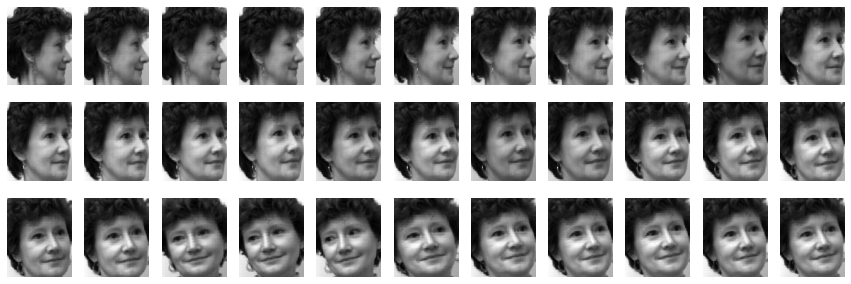

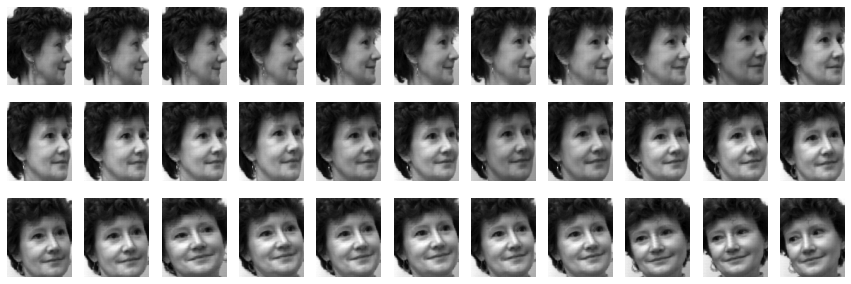

In [4]:
# Correct angle labels

angle_true_of_images = mat['id'][0].copy()
ImgIdx_seq_true = np.argsort(angle_true_of_images)
print(ImgIdx_seq_true)
print(angle_true_of_images[ImgIdx_seq_true])
draw_face_subplots(images[:,:,ImgIdx_seq_true],basesize=5)

angle_true_of_images[ImgIdx_seq_true[24:27]]+=100
ImgIdx_seq_true = np.argsort(angle_true_of_images)
print(ImgIdx_seq_true)
print(angle_true_of_images[ImgIdx_seq_true])
draw_face_subplots(images[:,:,ImgIdx_seq_true],basesize=5)

# Latter, we use angle_true_of_images to 
#   convert the sequence of images idx to the sequence of angles, 
#   and evaluate the orderness of angels orders.

In [5]:
# Numeric eveluation of the order quality

# In computer science and discrete mathematics, an inversion in a sequence is a pair of elements that are out of their natural order.
# https://en.wikipedia.org/wiki/Inversion_(discrete_mathematics)

# funtion to count the number of inversions in a sequence
def count_inversions_up(seq):
    """Count the number of inversions in a sequence."""
    if len(seq) <= 1:
        return 0
    mid = len(seq) // 2
    left = seq[:mid]
    right = seq[mid:]
    inv = count_inversions(left) + count_inversions(right)
    i, j = 0, 0
    while i < len(left) and j < len(right):
        if left[i] <= right[j]:
            i += 1
        else:
            inv += len(left) - i
            j += 1
    return inv

def count_inversions(seq):
    up_inv = count_inversions_up(seq)
    down_inv = count_inversions_up(seq[::-1])
    return min(up_inv, down_inv)

a = [1, 3, 5, 2, 4, 6]
print(count_inversions(a))

3


In [6]:
# get order from embedding by greedy nearest neighbor, and start seed

# input1: a 2xN matrix, 2d embedding of N points
# input2: idx(start from 0) of the start point
# find the next point with the smallest distance to current point
def get_order(Y_emb, start_idx):
    num_points = Y_emb.shape[1]
    order_map = np.zeros(num_points, dtype=int)
    order_map[start_idx] = 1
    cur_idx = start_idx
    for i in range(num_points-1):
        # calculate distance from current point to all other points
        dist = Y_emb - Y_emb[:, cur_idx].reshape(2, 1)
        dist = np.linalg.norm(dist, axis=0)
        dist[order_map>0] = 1000000
        next_idx = np.argmin(dist)
        order_map[next_idx] = i+2
        cur_idx = next_idx
    return order_map


# Question 1: Diffusion Map

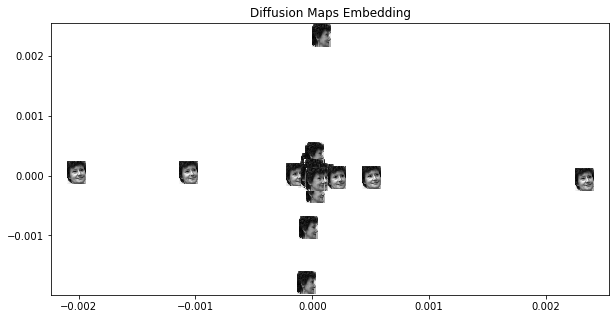

(x)Diffusion_order:  [ 33  30  23   2 127  15   4  21   8  18  19   6  12  13  17  10 126  28
   5  11   1   9   7  16 125  14  20  22   3  29  24  31  32]
(x)Inversions:  62
(nearest) Diffusion_order:  [  3   1   6   5  16  13   8 126  10  28  11  19  18  12  21 127  15  17
   9  14 125  22  20  29  24   7  23  31   4   2  30  33  32]
(nearest) Inversions:  77


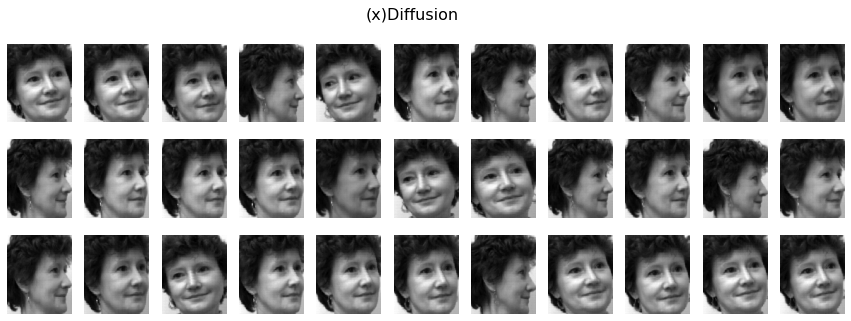

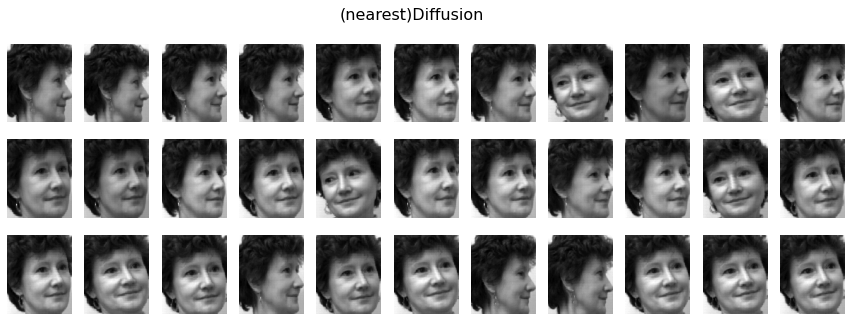

In [8]:

# # Diffusion map function
# def diffusion_map(X, t=1):
#     pairwise_dists = pairwise_distances(X)
#     W = np.exp(-pairwise_dists / t)
#     D = np.diag(np.sum(W, axis=1))
#     L = np.linalg.inv(D) @ (W - np.eye(W.shape[0]))

#     # Compute eigenvalues and eigenvectors
#     eigenvalues, eigenvectors = eigh(L)
#     print(eigenvalues.shape)
#     print(eigenvectors.shape)

#     # Sort faces by second smallest nonzero eigenvalue
#     second_smallest_eigenvector = eigenvectors[:, 1]
#     sorted_indices = np.argsort(second_smallest_eigenvector)

#     return sorted_indices,eigenvectors[:,:2]

# sorted_faces_diffusion, difmap = diffusion_map(X)
# draw_face_subplots(images[:,:,sorted_faces_diffusion],titles='Diffusion map')
# inversions_diffusion = count_inversions(angle_true_of_images[sorted_faces_diffusion])
# print('\033[91m' + 'Inversions: ', inversions_diffusion)

# fig, axs = plt.subplots(1, 1, figsize=(10, 5))
# axs.scatter(difmap[:, 0], difmap[:, 1])
# # draw_image_at_point(imgs=images, Y_emb=difmap.T, axs=axs)


# Initialize and fit the SpectralEmbedding model
embedding_model = SpectralEmbedding(n_components=2, affinity='precomputed')
distances = pairwise_distances(X)
diffusion_map = embedding_model.fit_transform(distances)
# convert all minus values to positive; folder the pseudo center-symmetric reuslts
# diffusion_map[:,0] = np.abs(diffusion_map[:,0])
sorted_indices_diffusion = np.argsort(diffusion_map[:,0])

# Plot the embedding
# diffusion_map[:,1] = np.abs(diffusion_map[:,1])
fig, axs = plt.subplots(1, 1, figsize=(10, 5))
axs.scatter(diffusion_map[:, 0], diffusion_map[:, 1])
draw_image_at_point(imgs=images, Y_emb=diffusion_map.T, axs=axs)
axs.set_title("Diffusion Maps Embedding")
plt.show()


draw_face_subplots(images[:,:,sorted_indices_diffusion],titles='(x)Diffusion')
inversions_diffusion = count_inversions(angle_true_of_images[sorted_indices_diffusion])
print('\033[94m' + '(x)Diffusion_order: ',angle_true_of_images[sorted_indices_diffusion])
print('\033[91m' + '(x)Inversions: ', inversions_diffusion)

Diffusion_start_idx = np.argmax(diffusion_map[:, 1])
Diffusion_order_map = get_order(diffusion_map.T, Diffusion_start_idx)
draw_face_subplots(images[:,:,np.argsort(Diffusion_order_map)],titles='(nearest)Diffusion')
Diffusion_order = angle_true_of_images[np.argsort(Diffusion_order_map)]
print('\033[94m' + "(nearest) Diffusion_order: ",Diffusion_order)
print('\033[91m' + "(nearest) Inversions: ", count_inversions(Diffusion_order))




The visualization shows the 33 faces sorted based on the second smallest eigenvector. 

# Question 2: MDS-embedding

In [22]:
mds_inv_s = []
mds_inv_n = []

In [ ]:
for i in range(100):
    # MDS-embedding
    mds = MDS(n_components=2)
    X_mds = mds.fit_transform(X)

    # Sort faces by first eigenvector
    sorted_indices_mds = np.argsort(X_mds[:, 0])

    # Visualize MDS Embedding (2D scatter plot)
    fig, axs = plt.subplots(1, 1, figsize=(10, 5))
    axs.scatter(X_mds[:, 0], X_mds[:, 1])
    draw_image_at_point(imgs=images, Y_emb=X_mds.T, axs=axs)
    # for i, txt in enumerate(sorted_indices_mds):
    #     axs.annotate(txt, (X_mds[i, 0], X_mds[i, 1]),color='red')
    axs.set_title("MDS Embedding")
    axs.set_xlabel("First Eigenvector")
    axs.set_ylabel("Second Eigenvector")
    plt.show()

    draw_face_subplots(images[:,:,sorted_indices_mds],titles='(x)MDS')
    inversions_mds = count_inversions(angle_true_of_images[sorted_indices_mds])
    print('\033[94m' + '(x)MDS_order: ',angle_true_of_images[sorted_indices_mds])
    print('\033[91m' + '(x)Inversions: ', inversions_mds)
    mds_inv_s.append(inversions_mds)


    MDS_start_idx = np.argmax(X_mds[:, 1])
    MDS_order_map = get_order(X_mds.T, MDS_start_idx)
    draw_face_subplots(images[:,:,np.argsort(MDS_order_map)],titles='(nearest)MDS')
    MDS_order = angle_true_of_images[np.argsort(MDS_order_map)]
    print('\033[94m' + "(nearest) MDS_order: ",MDS_order)
    print('\033[91m' + "(nearest) Inversions: ", count_inversions(MDS_order))
    mds_inv_n.append(count_inversions(MDS_order))


In [24]:
print(mds_inv_s)
print(mds_inv_n)

# calculate the avg and std of inversions
mds_inv_s_avg = np.mean(mds_inv_s)
mds_inv_s_std = np.std(mds_inv_s)
mds_inv_n_avg = np.mean(mds_inv_n)
mds_inv_n_std = np.std(mds_inv_n)
print('\033[94m' + "MDS_inversions_avg: ",mds_inv_s_avg)
print('\033[94m' + "MDS_inversions_std: ",mds_inv_s_std)
print('\033[94m' + "MDS_inversions_avg(nearest): ",mds_inv_n_avg)
print('\033[94m' + "MDS_inversions_std(nearest): ",mds_inv_n_std)


[3, 76, 69, 70, 23, 16, 26, 25, 18, 43, 53, 22, 40, 50, 80, 52, 68, 84, 68, 39, 53, 22, 135, 34, 27, 22, 0, 20, 73, 33, 57, 28, 64, 70, 74, 57, 56, 51, 30, 53, 24, 18, 44, 45, 28, 32, 81, 24, 23, 22, 71, 2, 10, 17, 76, 37, 18, 36, 20, 99, 21, 14, 45, 26, 39, 22, 56, 30, 38, 58, 23, 77, 48, 43, 89, 23, 54, 82, 66, 86, 27, 26, 38, 65, 29, 11, 13, 36, 42, 14, 61, 15, 70, 31, 12, 47, 52, 109, 42, 41]
[227, 205, 11, 76, 88, 33, 205, 71, 19, 92, 205, 71, 88, 17, 92, 108, 20, 90, 108, 205, 21, 227, 233, 92, 92, 13, 13, 9, 92, 11, 20, 205, 227, 20, 149, 13, 233, 109, 6, 92, 205, 205, 9, 11, 205, 13, 109, 7, 15, 227, 199, 108, 205, 6, 205, 205, 13, 104, 33, 104, 92, 13, 88, 13, 13, 90, 233, 227, 92, 104, 13, 11, 88, 92, 13, 13, 20, 227, 37, 204, 38, 92, 155, 233, 227, 204, 13, 92, 205, 13, 92, 15, 20, 14, 205, 205, 227, 109, 108, 104]
MDS_inversions_avg:  43.32
MDS_inversions_std:  25.254655016451917
MDS_inversions_avg(nearest):  101.5
MDS_inversions_std(nearest):  81.14363807471292


[Text(1, 0, 'mds_Iv_x'), Text(2, 0, 'mds_Iv_n')]

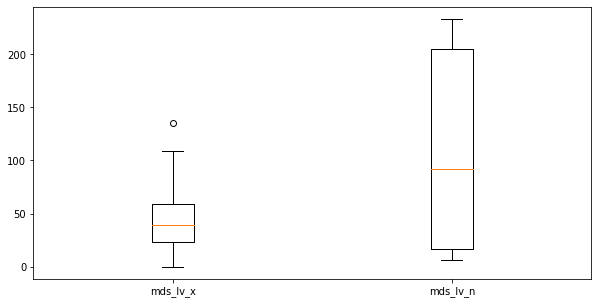

In [27]:
# box plot of mds_inv_s,mds_inv_n
fig, axs = plt.subplots(1, 1, figsize=(10, 5))
axs.boxplot([mds_inv_s,mds_inv_n])
# set xticklabels
axs.set_xticklabels(['mds_Iv_x','mds_Iv_n'])


The first visualization is a 2D scatter plot showing the MDS embedding of the faces. Each point in the scatter plot represents a face, and the distances between the points represent the pairwise dissimilarities between the faces. It can be observed that the distribution of the faces in the 2D space formed by the top two eigenvectors.

The second visualization shows the 33 faces sorted based on the top first eigenvector. The order is intended to represent the faces in a sequence that preserves the pairwise distances between the faces in the high-dimensional space. This way, we can observe how the faces transition from one angle to another. However, some discontinuities in the ordering can still be observed, which might be due to the limitations of the MDS method in preserving the exact pairwise distances in the lower-dimensional space.

# Question 3: ISOMAP-embedding

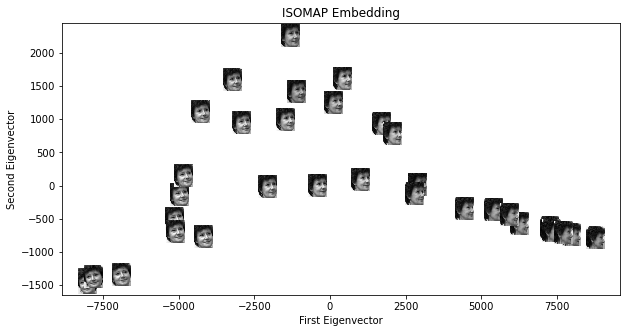

(x) isomap_order:  [127 126 125  28  32  33  29  30  24  31  23  22  21  20  19  18  17  16
  15  14  13  12  11  10   9   8   7   6   5   4   3   2   1]
(x) Inversions:  6
(nearest) isomap_order:  [  1   2   3   4   5   6   7   8   9  10  11  12  13  14  17  16  15  18
  20  21  22  23  24  30  29  32  33  31  28 125 127 126  19]
(nearest) Inversions:  7


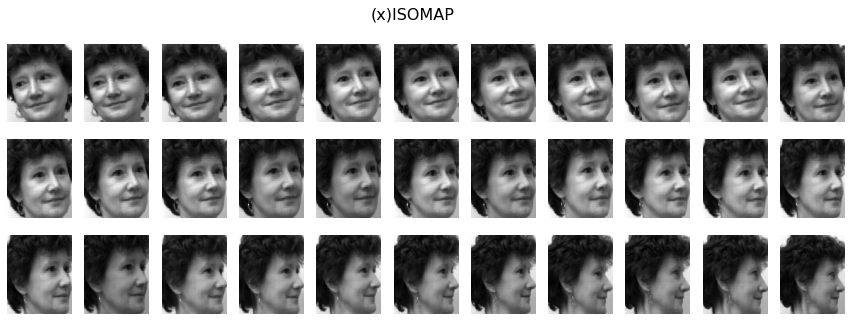

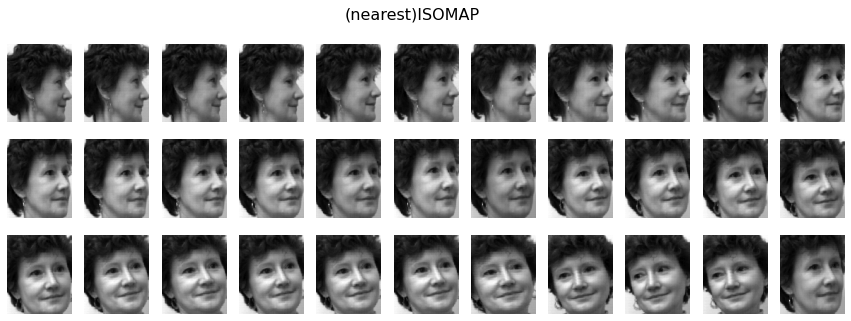

In [67]:
# ISOMAP-embedding
isomap = Isomap(n_neighbors=5, n_components=2)
X_isomap = isomap.fit_transform(X)

# Visualize ISOMAP Embedding (2D scatter plot)
fig, axs = plt.subplots(1, 1, figsize=(10, 5))
axs.scatter(X_isomap[:, 0], X_isomap[:, 1])
draw_image_at_point(imgs=images, Y_emb=X_isomap.T, axs=axs)

# for i, txt in enumerate(range(len(X_isomap))):
#     axs.annotate(txt, (X_isomap[i, 0], X_isomap[i, 1]))
axs.set_title("ISOMAP Embedding")
axs.set_xlabel("First Eigenvector")
axs.set_ylabel("Second Eigenvector")
plt.show()

# Sort faces by first eigenvector
sorted_indices_isomap = np.argsort(X_isomap[:, 0])

draw_face_subplots(images[:,:,sorted_indices_isomap],titles='(x)ISOMAP')
inversions_isomap = count_inversions(angle_true_of_images[sorted_indices_isomap])
print('\033[94m' + "(x) isomap_order: ",angle_true_of_images[sorted_indices_isomap])
print('\033[91m' + '(x) Inversions: ', inversions_isomap)

isomap_start_idx = np.argmax(X_isomap[:, 0])
isomap_order_map = get_order(X_isomap.T, isomap_start_idx)
draw_face_subplots(images[:,:,np.argsort(isomap_order_map)],titles='(nearest)ISOMAP')
isomap_order = angle_true_of_images[np.argsort(isomap_order_map)]
print('\033[94m' + "(nearest) isomap_order: ",isomap_order)
print('\033[91m' + "(nearest) Inversions: ", count_inversions(isomap_order))



**Trying the ISOMAP-embedding in sklearn Python Library, which is similiar to Tenenbaum's Matlab code.**

The first visualization is a 2D scatter plot showing the ISOMAP embedding of the faces. Each point in the scatter plot represents a face, and the distances between the points represent the geodesic distances between the faces. It can be observed that the distribution of the faces in the 2D space formed by the top two eigenvectors.

The second visualization shows the 33 faces sorted based on the top first eigenvector from the ISOMAP embedding. Similar to MDS, the order is intended to represent the faces in a sequence that preserves the geodesic distances between the faces in the high-dimensional space. 

**By comparing the ISOMAP results with the MDS results, it can be observed that the ISOMAP method provides a smoother transition between the face angles, which suggests that the ISOMAP technique captures the underlying nonlinear structure of the data more effectively than MDS.**

# Question  4: LLE/MLLE-embedding

(nearest) lle_order:  [  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  30  29  31  33  32  28 125 127 126]
(nearest) mlle_order:  [  1   2   4   3   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  30  29  31  32  33  28 125 126 127]
(nearest) Inversions:  2
(nearest) Inversions:  0
(lle) lle_order:  [  1   2   3   4   5   6   7   8   9  11  10  12  13  14  15  16  17  18
  19  20  21  22  23  24  30  29  31  33  32  28 125 126 127]
(lle) mlle_order:  [127 126 125  28  33  32  31  29  30  24  22  21  23  20  19  18  17  16
  15  14  13  12  10  11   9   8   7   6   5   3   4   2   1]
(x) Inversions:  3
(x) Inversions:  3


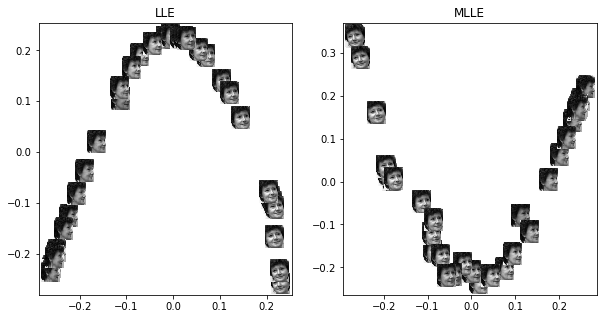

In [76]:
from sklearn.manifold import LocallyLinearEmbedding

# LLE/MLLE-embedding of the 33 faces on the k = 5 nearest neighbor graph

k = 5
lle = LocallyLinearEmbedding(n_neighbors=k, n_components=2, method='standard')
Y_lle = lle.fit_transform(X).T


# MLLE-embedding of the 33 faces on the k = 5 nearest neighbor graph
#

k = 5
mlle = LocallyLinearEmbedding(n_neighbors=k, n_components=2, method='modified')
Y_mlle = mlle.fit_transform(X).T

# Visualize LLE/MLLE-embedding of the 33 faces on the k = 5 nearest neighbor graph

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].scatter(Y_lle[0], Y_lle[1], c='r', marker='o')
draw_image_at_point(imgs=images, Y_emb=Y_lle, axs=axs[0])
axs[0].set_title('LLE')
# axs[0].axis('off')

axs[1].scatter(Y_mlle[0], Y_mlle[1], c='b', marker='o')
draw_image_at_point(imgs=images, Y_emb=Y_mlle, axs=axs[1])
axs[1].set_title('MLLE')
# axs[1].axis('off')

lle_order = np.zeros(33, dtype=int)
lle_start_idx = np.argmin(Y_lle[0])
lle_order_map = get_order(Y_lle, lle_start_idx)
mlle_order = np.zeros(33, dtype=int)
mlle_start_idx = np.argmax(Y_mlle[0])
mlle_order_map = get_order(Y_mlle, mlle_start_idx)

lle_order = angle_true_of_images[np.argsort(lle_order_map)]
mlle_order = angle_true_of_images[np.argsort(mlle_order_map)]
print('\033[94m' + "(nearest) lle_order: ",lle_order)
print('\033[94m' + "(nearest) mlle_order: ",mlle_order)


# print(count_inversions(lle_order))
print('\033[91m' + '(nearest) Inversions: ', count_inversions(lle_order))
# print(count_inversions(mlle_order))
print('\033[91m' + '(nearest) Inversions: ', count_inversions(mlle_order))

lle_order = angle_true_of_images[np.argsort(Y_lle[0])]
mlle_order = angle_true_of_images[np.argsort(Y_mlle[0])]
print('\033[94m' + "(lle) lle_order: ",lle_order)
print('\033[94m' + "(lle) mlle_order: ",mlle_order)

# print(count_inversions(lle_order))
print('\033[91m' + '(x) Inversions: ', count_inversions(lle_order))
# print(count_inversions(mlle_order))
print('\033[91m' + '(x) Inversions: ', count_inversions(mlle_order))



# Question  5: LSTA-embedding

(nearest) ltsa_order [  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  20
  18  21  19  22  23  24  30  32  33  31  29  28 125 126 127]
(nearest) Inversions:  12
(x) ltsa_order [127 126 125  28  33  32  30  31  29  24  23  22  21  19  20  18  17  16
  15  14  13  12  11  10   9   8   7   6   5   4   3   2   1]
(x) Inversions:  1


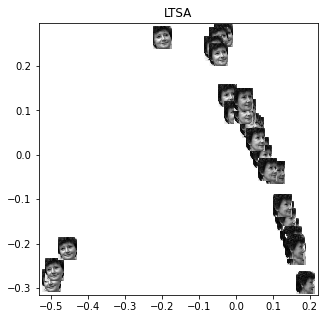

In [69]:
from sklearn.manifold import LocallyLinearEmbedding
# OffsetImage,AnnotationBbox

# LTSA-embedding of the 33 faces on the k = 5 nearest neighbor graph

k = 5
ltsa = LocallyLinearEmbedding(n_neighbors=k, n_components=2, method='ltsa')
Y_ltsa = ltsa.fit_transform(X).T

# Visualize LTSA-embedding of the 33 faces on the k = 5 nearest neighbor graph

fig, axs = plt.subplots(1, 1, figsize=(5, 5))

axs.scatter(Y_ltsa[0], Y_ltsa[1], c='g', marker='o')

# Set the image for each point
x = Y_ltsa[0]
y = Y_ltsa[1]
num_points = Y_ltsa.shape[1]
draw_image_at_point(imgs=images, Y_emb=Y_ltsa, axs=axs)
axs.set_title('LTSA')

ltsa_order = np.zeros(33, dtype=int)
ltsa_start_idx = np.argmax(Y_ltsa[0])
ltsa_order_map = get_order(Y_ltsa, ltsa_start_idx)
ltsa_order = angle_true_of_images[np.argsort(ltsa_order_map)]
print('\033[94m' + "(nearest) ltsa_order" ,ltsa_order)
# print(count_inversions(ltsa_order))
print('\033[91m' + '(nearest) Inversions: ', count_inversions(ltsa_order))

ltsa_order = angle_true_of_images[np.argsort(Y_ltsa[0])]
print('\033[94m' + "(x) ltsa_order" ,ltsa_order)
# print(count_inversions(ltsa_order))
print('\033[91m' + '(x) Inversions: ', count_inversions(ltsa_order))



In [28]:
invs_x = []
invs_n = []

# Question  6: 2-D t-SNE embedding

In [29]:
from sklearn.manifold import TSNE

# 2-d t-sne embedding of the 33 faces

for i in range(100):

    tsne = TSNE(n_components=2, perplexity=5, learning_rate=100, n_iter=1000)

    Y_tsne = tsne.fit_transform(X).T

    # Visualize 2-d t-sne embedding of the 33 faces

    # fig, axs = plt.subplots(1, 1, figsize=(5, 5))

    # axs.scatter(Y_tsne[0], Y_tsne[1], c='g', marker='o')
    # draw_image_at_point(imgs=images, Y_emb=Y_tsne, axs=axs)
    # axs.set_title('t-SNE')

    tsne_order = np.zeros(33, dtype=int)
    tsne_start_idx = np.argmin(Y_tsne[0])
    tsne_order_map = get_order(Y_tsne, tsne_start_idx)
    tsne_order = angle_true_of_images[np.argsort(tsne_order_map)]

    # print('\033[94m' + "(nearest) tsne_order" ,tsne_order)
    # print('\033[91m' + '(nearest) Inversions: ', count_inversions(tsne_order))
    invs_n.append(count_inversions(tsne_order))

    tsne_order = angle_true_of_images[np.argsort(Y_tsne[0])]
    # print('\033[94m' + "(x) tsne_order" ,tsne_order)
    # print('\033[91m' + '(x) Inversions: ', count_inversions(tsne_order))
    invs_x.append(count_inversions(tsne_order))


In [30]:
print(invs_n)
print(invs_x)

# calculate the average and std of inversions
print('\033[94m' + "(nearest) Average Inversions: ", np.mean(invs_n))
print('\033[94m' + "(nearest) Std Inversions: ", np.std(invs_n))
print('\033[94m' + "(x) Average Inversions: ", np.mean(invs_x))
print('\033[94m' + "(x) Std Inversions: ", np.std(invs_x))


[0, 112, 112, 136, 6, 104, 114, 112, 82, 0, 6, 4, 10, 112, 112, 56, 36, 241, 112, 54, 4, 4, 112, 112, 239, 144, 114, 112, 0, 4, 112, 4, 112, 112, 0, 4, 250, 4, 4, 6, 4, 9, 83, 4, 114, 112, 24, 0, 0, 112, 0, 4, 4, 112, 54, 114, 168, 112, 54, 54, 5, 114, 112, 224, 173, 112, 37, 112, 6, 112, 112, 0, 112, 2, 112, 4, 0, 4, 112, 112, 112, 4, 112, 112, 0, 114, 9, 112, 8, 112, 102, 112, 112, 6, 4, 308, 112, 112, 4, 52]
[69, 2, 12, 190, 12, 16, 8, 5, 313, 70, 10, 8, 35, 5, 12, 41, 76, 33, 13, 20, 9, 15, 93, 248, 327, 172, 50, 9, 26, 22, 96, 16, 15, 1, 12, 1, 3, 8, 10, 11, 1, 303, 36, 34, 8, 8, 94, 15, 22, 18, 10, 10, 14, 6, 140, 9, 67, 13, 62, 53, 26, 10, 9, 2, 177, 9, 22, 21, 8, 15, 6, 77, 16, 10, 14, 8, 194, 8, 8, 9, 8, 8, 9, 2, 14, 225, 16, 44, 8, 10, 156, 7, 12, 8, 8, 390, 15, 6, 35, 74]
(nearest) Average Inversions:  73.08
(nearest) Std Inversions:  66.85172847428854
(x) Average Inversions:  47.21
(x) Std Inversions:  77.69907271003946


[Text(1, 0, 'mds_Iv_one_component'),
 Text(2, 0, 'mds_Iv_nearest_nerbor'),
 Text(3, 0, 't-sne_Iv_one_component'),
 Text(4, 0, 't-sne_Iv_nearest_nerbor')]

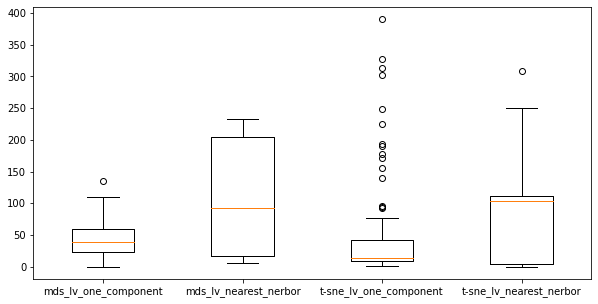

In [31]:
# box plot of mds_inv_s,mds_inv_n,invs_n and invs_x
fig, axs = plt.subplots(1, 1, figsize=(10, 5))
axs.boxplot([mds_inv_s,mds_inv_n, invs_x,invs_n])
# set xticklabels
axs.set_xticklabels(['mds_Iv_one_component','mds_Iv_nearest_nerbor','t-sne_Iv_one_component','t-sne_Iv_nearest_nerbor'])
